# Embedding creation and visualization

## Introduction

Embeddings are a technique used to represent data in a more compact and meaningful way. In particular, they are used to represent high-dimensional vectors (e.g., word or image representations) in a lower dimensional space (usually a few tens or hundreds of dimensions).

They are very useful in machine learning applications involving natural language processing. For example, they can be used to represent words in a vector space, so that words that have a similar meaning are represented close to each other. This is useful in tasks such as machine translation, where one seeks to find the word in the target language that has the closest meaning to the word in the source language.

## Goals

In this notebook we will create an Embedding and project it in a two-dimensional space to test how words can be related in a vector space in a given context (problem).

We will train this embedding for a classification task typically used to start learning NLP, that of sentiment analysis of IMDb comments. However, we will stay at the point where the embedding is trained.

## Libraries and configuration

Next we will import the libraries that will be used throughout the notebook.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

We will also configure some parameters to adapt the graphic presentation.

In [3]:
np.set_printoptions(precision=3)

plt.style.use('bmh')
plt.rcParams.update({'figure.figsize': (16, 9),'figure.dpi': 100})

***

## Getting the [IMDb](https://www.imdb.com/) dataset

We are going to use the dataset from IMDb as our data source. Fortunately, we have it in the `datasets` module of Keras, so we can load it in the same way as we have done with the `mnist` dataset.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

17464789/17464789 [==============================] - 1s 0us/step


The downloaded comments are actually indexes to words. The `word->index` dictionary is obtained with the `get_word_index` function. We will get the dictionary and do the reverse dictionary in order to do the decoding.

In [5]:
word_index = tf.keras.datasets.imdb.get_word_index()
index_word = {index: word for (word, index) in word_index.items()}

' '.join(index_word.get(i, '<UNK>') for i in x_train[0])

1641221/1641221 [==============================] - 0s 0us/step


"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but wh

Doesn't make much sense, does it? That's because this vocabulary dictionary is a bit of a cheat, since it doesn't correspond exactly to the data in the dataset:

- The first index of all is 1, not 0. 0 is not used.
- The indexes are shifted 3 integers because that refers to reserved words (index 1 to beginning of phrase, 2 to unknown item and 3 to not used...).

Therefore, we are going to fill in three positions to run all the indexes and fill in the default values. The 0 will be used to indicate a padding (to fill the sentences that do not have the fixed length required by the models). Finally, we will generate again the inverse dictionary

In [6]:
word_index = {word: (index + 3) for word, index in word_index.items()} 
word_index['<PAD>'] = 0  # Padding
word_index['<SOS>'] = 1  # Start-of-sentence
word_index['<UNK>'] = 2  # Unknown
word_index['<UNU>'] = 3  # Unused

index_word = {index: word for (word, index) in word_index.items()}

' '.join(index_word.get(i, '<UNK>') for i in x_train[0])

"<SOS> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

Let's deal with the first problem. To get a fixed length entry, we can simply truncate the reviews to a fixed number of words, say 64. For reviews longer than 64 words, we will keep only the first 64 words. For shorter reviews, we will fill the unused word gaps with the value we have assigned to the padding (the 0). With keras, this is easy to do using the `pad_sequences` function:

In [7]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train,
    value=word_index['<PAD>'],
    padding='post',
    maxlen=64
)
x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test,
    value=word_index['<PAD>'],
    padding='post',
    maxlen=64
)
print(f"Sequence: {', '.join(str(i) for i in x_train[0])}")
print(f"Comment:  {' '.join(index_word.get(i, '<UNK>') for i in x_train[0])}")

Sequence: 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32
Comment:  out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all


## Use of the Embedding layer

Keras makes it **much** easier to work with _Embeddings_ thanks to the `Embedding` layer, which can be understood as a dense layer that maps from integer indexes (the indexes of the specific words) to word vectors (their corresponding _embeddings_).

The `Embeddings` are created with two parameters; the first one (`input_dim`), the number of words, indicates how many words our embedding will take into account. All those not found in the embedding will return a representation for an "unknown" token. The higher this parameter is, the more words can be represented but the more it will take up in memory and, above all, the more parameters will have to be trained.

The second parameter (`output_dim`) is the dimension. This parameter indicates the number of qualities that will be stored for each word of the embedding. This is the parameter that you play with the most when you are creating an embedding from 0 to solve a problem, in the same way that you experiment with the number of neurons in a `Dense` layer.

For example, let's create an _embedding_ with any number of words and dimension.

In [8]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=1000,  # Maximum items to encode
    output_dim=5,    # How many dimensions represent each item
)

When an `Embedding` layer is created, its weights are initialized randomly (as with any other layer). During training they will be gradually adjusted by backpropagation.

Once trained, the learned word vectors can be expected to encode roughly similarities between words since, after all, they were learned for the specific problem on which the model is trained.

If an integer (i.e., the index representing a word) is passed to an `Embedding` layer, it replaces it with its corresponding word vector:

In [9]:
result = embedding_layer(tf.constant([1,2,4,8]))
result.numpy()

array([[ 0.02 , -0.035,  0.017, -0.033,  0.034],
       [-0.022, -0.018, -0.049,  0.043, -0.042],
       [-0.032, -0.002,  0.009, -0.032, -0.02 ],
       [-0.027, -0.   ,  0.037, -0.02 , -0.029]], dtype=float32)

For problems where we have a text instead of a single word, we can pass directly a 2D tensor, in the form `(num_sequences, sequence_length)`. The returned tensor will have the same form, but with one more dimension which will be the dimensions of the words.

For example, in the case of a two-dimensional input with the form `(2, 4)` (that is, 2 sequences of 4 items each), the returned tensor will have one more axis with the dimension we have declared in the _Embedding_:

In [10]:
result = embedding_layer(tf.constant([
    [0, 1, 2, 3],
    [4, 5, 6, 7],
]))
print(f'Result (shape = {result.numpy().shape}):\n{result.numpy()}')

Result (shape = (2, 4, 5)):
[[[ 0.04   0.047 -0.001 -0.045  0.017]
  [ 0.02  -0.035  0.017 -0.033  0.034]
  [-0.022 -0.018 -0.049  0.043 -0.042]
  [-0.005 -0.04   0.039 -0.016 -0.014]]

 [[-0.032 -0.002  0.009 -0.032 -0.02 ]
  [-0.002  0.017  0.001  0.007  0.01 ]
  [ 0.025 -0.001  0.036  0.039 -0.008]
  [-0.009  0.034  0.005 -0.015 -0.039]]]


We can see that if we give a _batch_ of sequences as input, an _Embedding_ returns a 3D tensor of type `float`, of the form `(num_sequences, items_per_sequence, embedding_dim)`.

## Classification model creation and training

We will use a sequential model formed by the `Embedding` and a dense layer. This model will be trained to try to give an answer to which comments are negative and which are positive.

Among all the weights that are trained, there will be those of the `Embedding`. Once the training is finished, our `Embedding` will have an understanding of the relationships that exist between our words, at least within our context of movies.

The model we will create will be a first `Embedding` layer (with a feature dimension of 2 so that we can plot the words) and a sigmoidal output layer that determines whether it is a good review or not. The rest of the intermediate layers as you wish. Then, we will compile the model in such a way as to use the corresponding loss function for a classification problem (remember, here it is binary), Adam as an optimizer and we will also pull out the accuracy during training.

In [11]:
WORDS_IN_VOCAB = len(word_index)
EMBEDDING_DIM  = 2

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(
        input_dim=WORDS_IN_VOCAB,
        output_dim=EMBEDDING_DIM,
    ),
    tf.keras.layers.LSTM(units=32),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 2)           177176    
                                                                 
 lstm (LSTM)                 (None, 32)                4480      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 181689 (709.72 KB)
Trainable params: 181689 (709.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


And now we train the model. We will do it for 5 epochs.

In [12]:
history = model.fit(x_train, y_train, epochs=5, verbose=1)

Epoch 1/5
782/782 [==============================] - 6s 7ms/step - loss: 0.4959 - binary_accuracy: 0.7406
Epoch 2/5
782/782 [==============================] - 6s 7ms/step - loss: 0.2814 - binary_accuracy: 0.8855
Epoch 3/5
782/782 [==============================] - 6s 7ms/step - loss: 0.1888 - binary_accuracy: 0.9296
Epoch 4/5
782/782 [==============================] - 6s 7ms/step - loss: 0.1270 - binary_accuracy: 0.9559
Epoch 5/5
782/782 [==============================] - 6s 7ms/step - loss: 0.0881 - binary_accuracy: 0.9705


Let's see the evolution of the training to check that the model is learning.

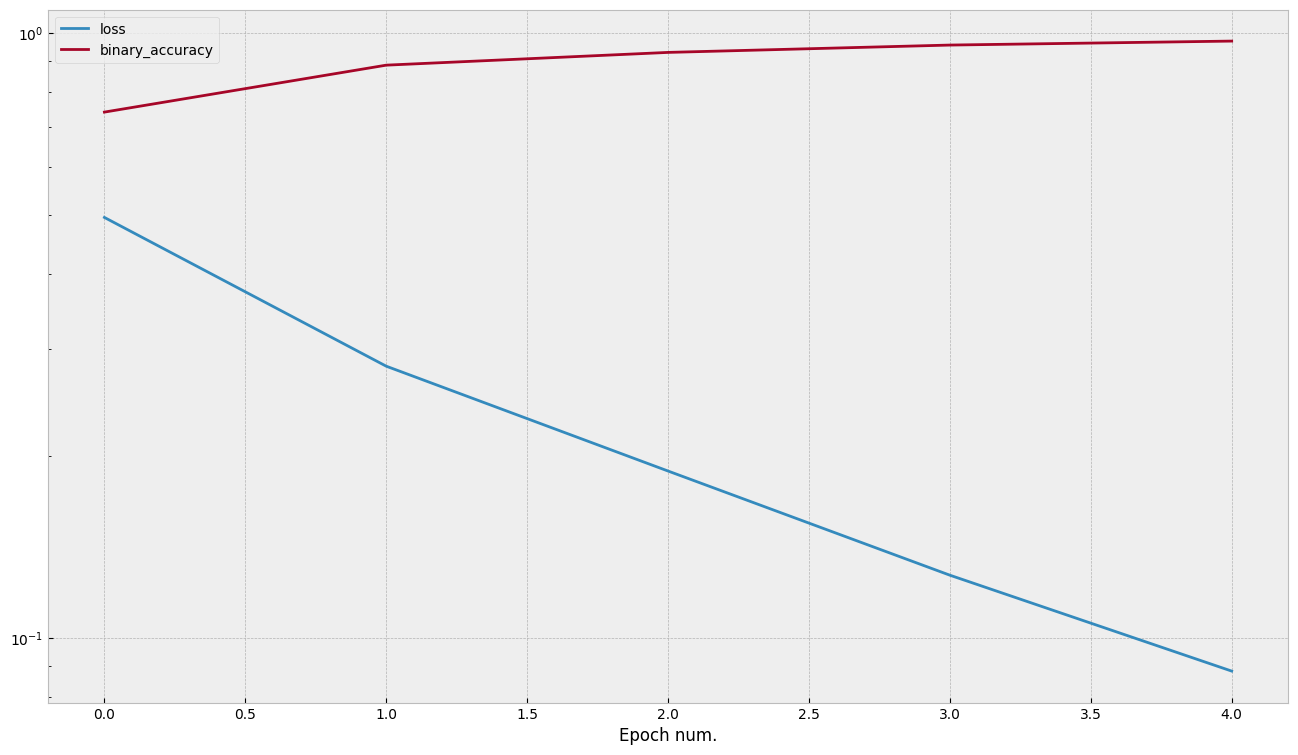

In [14]:
pd.DataFrame(history.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

## Embedding visualization

To see the `Embedding` represented, let's first create a function that will give us the output of our embedding layer for a given input.

In [15]:
f_embedding_out = tf.keras.backend.function(
    inputs=[model.layers[0].input],
    outputs=[model.layers[0].output],
)

We will use this function to obtain the distribution of the word vectors of the test set.

In [16]:
output = f_embedding_out(x_test[0])
print(f'Input shape:  {x_test[0].shape}')
print(f'Output shape: {output[0].shape}')

Input shape:  (64,)
Output shape: (64, 2)


It can be seen that, given a sequence, the output `output` is a list of a single tensor with the output sequence

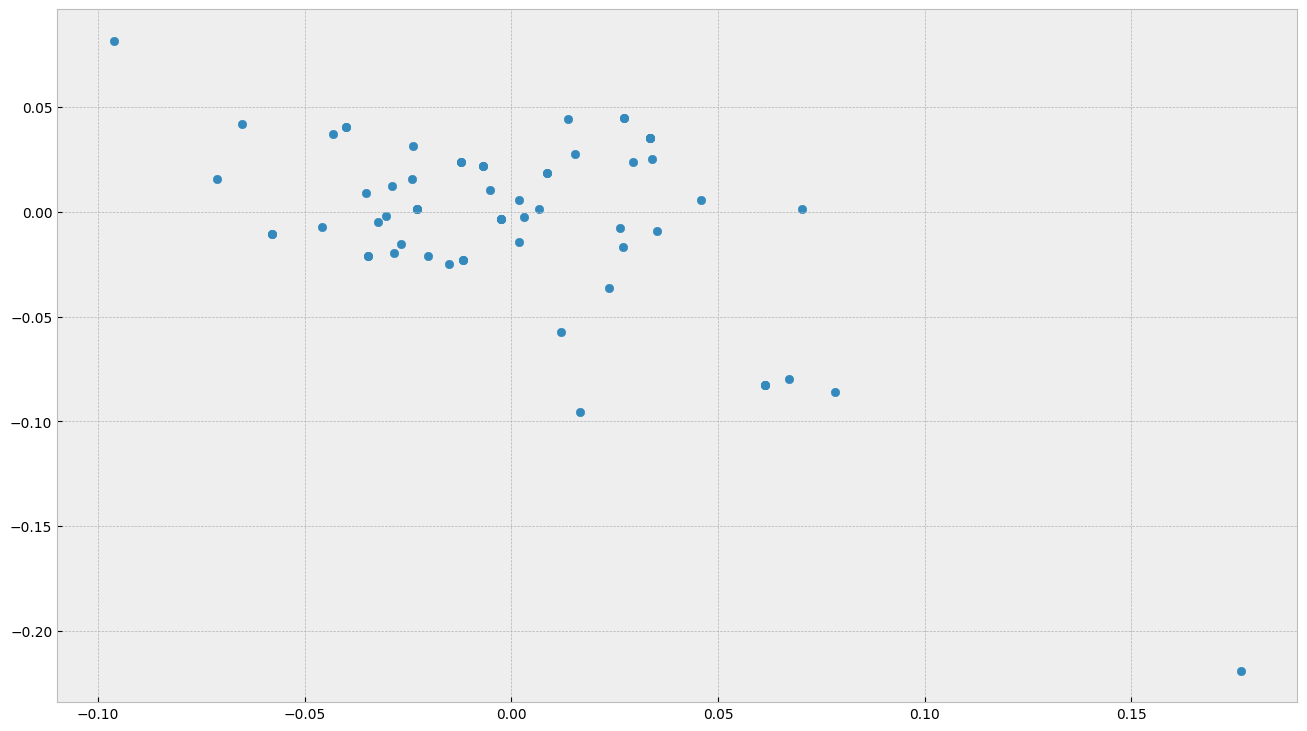

In [17]:
sentence_words = output[0]

plt.scatter(sentence_words[:,0], sentence_words[:,1])
plt.show();

Let's look at the vectors of the weights associated with certain words

In [18]:
weights = model.layers[0].get_weights()[0][:]
df = pd.DataFrame(weights, index=index_word.values())
df.loc[['cage', 'horrible', 'seagal', 'pascal'],:].head()

,0,1
cage,0.062917,-0.085122
horrible,-0.063805,0.103752
seagal,0.071169,-0.097225
pascal,0.083360,-0.094123


Let's create a fictitious movie review to see how the words are distributed:

In [19]:
review = ['cage', 'reeves', 'seagal', 'cavill', 'good', 'matrix', 'bad', 'crap', 'affleck']
encoded_review = tf.constant([word_index.get(w, word_index['<UNK>']) for w in review])
encoded_review.numpy()

array([1935, 5983, 3272,    2,   52, 2661,   78,  595, 6475], dtype=int32)

Now let's look at the `Embedding` output if we give it our review:

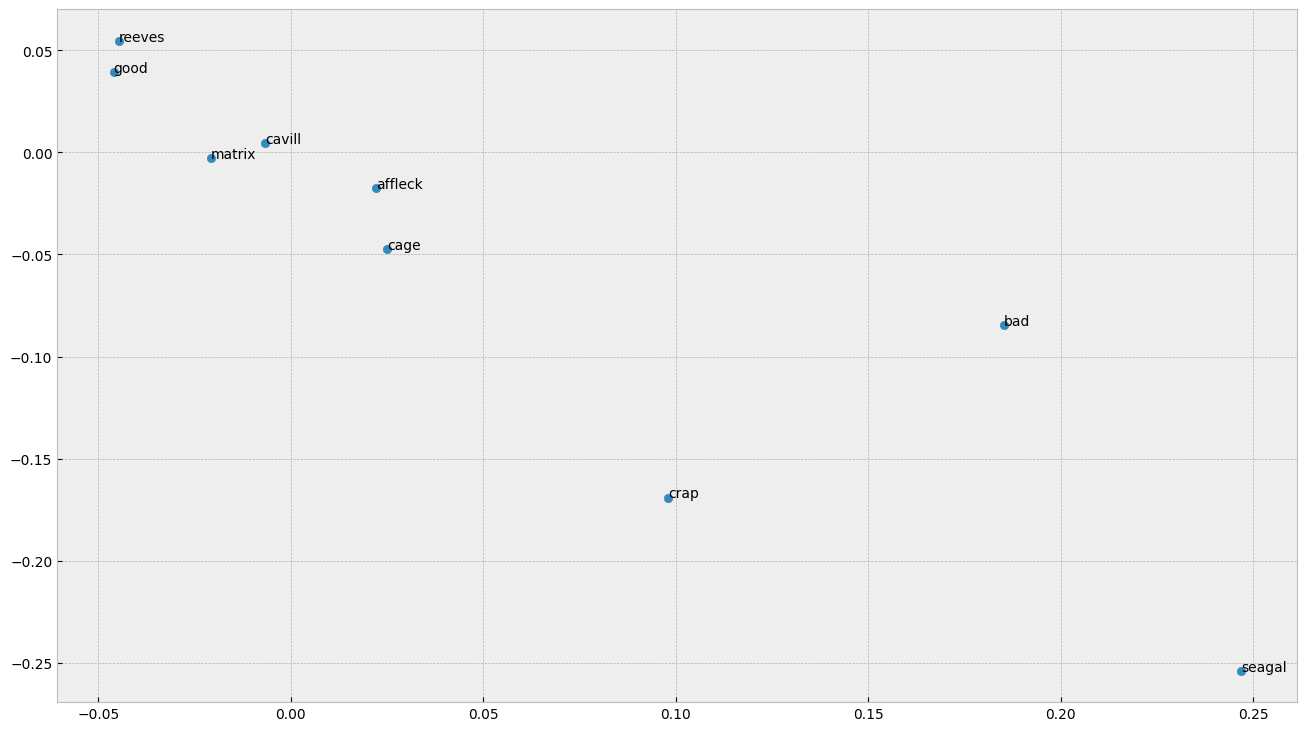

In [20]:
# We obtain the word vectors
v_words = f_embedding_out(encoded_review)[0]

# We show them annotated with their respective words
sentence_words = output[0]

plt.scatter(v_words[:,0], v_words[:,1])
for i, word in enumerate(review):
    plt.text(v_words[i, 0], v_words[i, 1], word)
plt.show();

In [21]:
encoded_review = tf.keras.preprocessing.sequence.pad_sequences(
    [encoded_review],
    value=word_index['<PAD>'],
    padding='post',
    maxlen=64
)

model.predict(encoded_review)

1/1 [==============================] - 0s 162ms/step


array([[0.006]], dtype=float32)

We see that in principle our embedding has spatially located the words that are most related. In this way, we can identify which actors are closer to which qualifiers according to their proximity to them.

## Conclusiones

We have created an embedding from certain data and demonstrated how it can create a representation in a vector space of the words included in it. This representation allows words that have similar meanings to be grouped together in the vector space, which can be useful for text analysis tasks such as document classification or information search. We have also shown how embedding can be used to perform tasks such as identifying unknown words and detecting misspelled words.

In general, the use of embeddings to represent text data is a valuable technique in machine learning and natural language processing. They allow words to be represented more meaningfully in a vector space, making it easier to identify patterns and perform classification and prediction tasks. In addition, their ability to cluster similar words together in vector space can significantly improve the accuracy and efficiency of text analysis models.